## Predicting heart disease using ML techniques

A task is to predict whether someone has a heart disease or not, based on given clinical parameters about a patient.

Original data is from UCI Machine Learinig Repository.

There are 13 features:
- age (in years)
- sex (1 - male, 0 - female)
- cp - chest pain type (1 - 4)
- trestbps - resting blood pressure (in mmHg)
- chol - serum cholesterol
- fbs - fasting blood sugar > 120 mg/ml (1 - true, 0 - false)
- restecg - resting ECG (0 - 2)
- thalach - max heart rate
- exang - exercise induced angina (1 - true, 0 - false)
- oldpeak - ST depression induced by exercise relative to rest
- slope - slope of the peak exercise ST segment (1 - 3)
- ca - num of major vessels colored by fluoroscopy (0 - 3)
- thal (0 - 3)
  
Labels:
- taget - have disease or not (1 - yes, 0 - no)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import auc, roc_curve, RocCurveDisplay 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv('./data/heart-disease.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
data.shape

(303, 14)

In [4]:
# check data types and missing values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


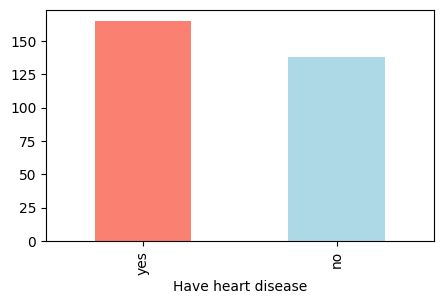

target
1    165
0    138
Name: count, dtype: int64

In [5]:
# check if classes are balanced

ax = data['target'].value_counts().plot(kind='bar',
                                   color=['salmon', 'lightblue'], 
                                   xlabel='Have heart disease',
                                   figsize=(5, 3))
ax.set_xticklabels(labels=['yes', 'no'])
plt.show()

data['target'].value_counts()

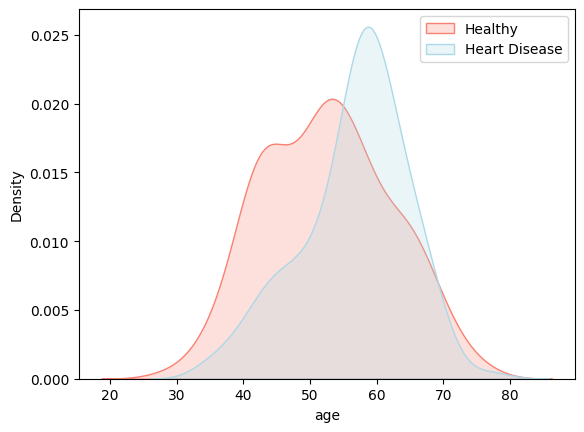

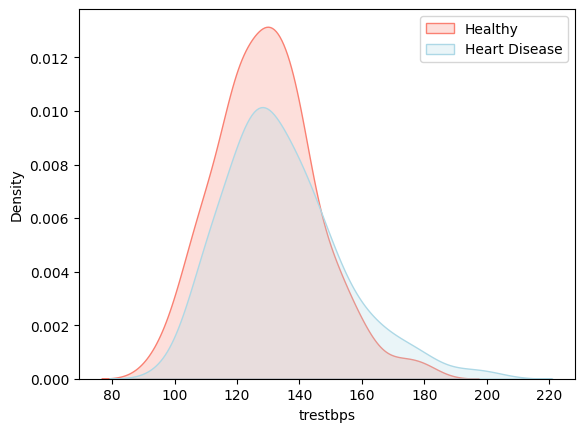

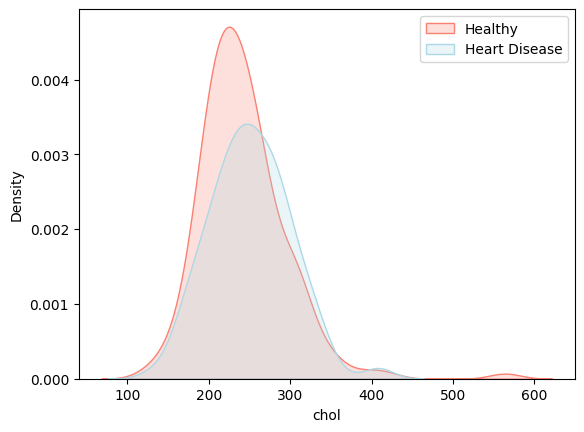

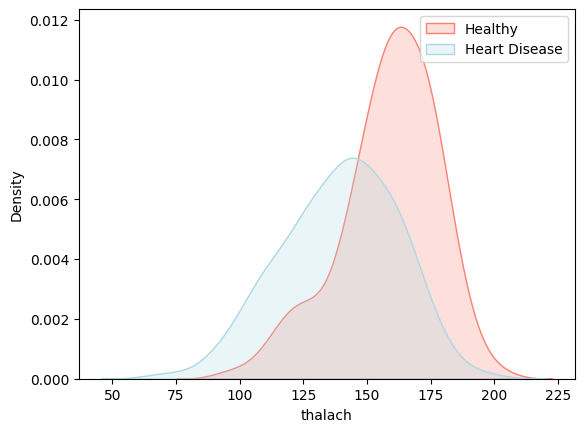

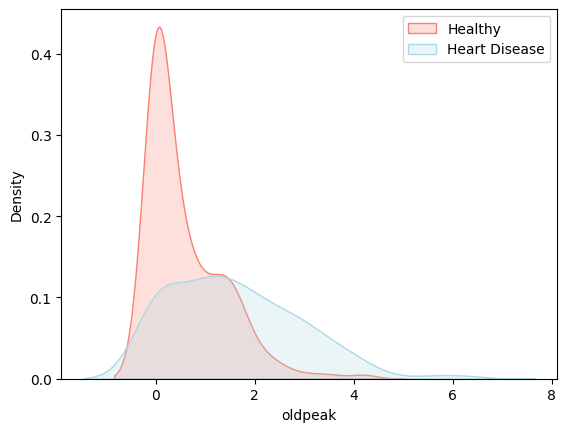

In [6]:
# KDE plots of "continuous" features for both labels

cont_feat = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for i in cont_feat:
    ax = sns.kdeplot(data=data, x=data[i], hue=data['target'], palette={0:'lightblue', 1:'salmon'}, fill=True)
    ax.legend(['Healthy', 'Heart Disease'])
    plt.show()

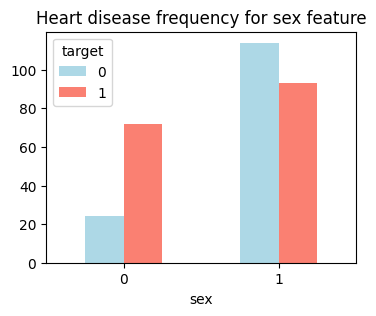

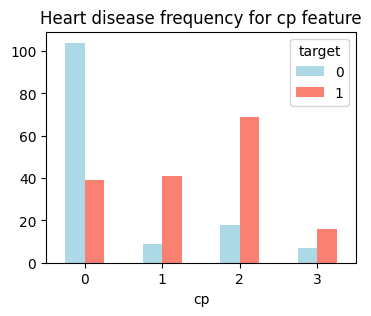

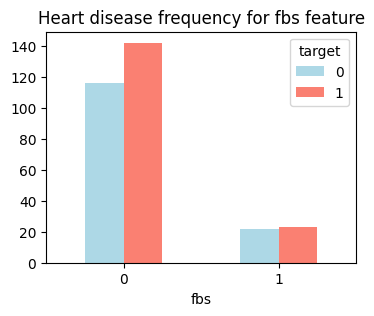

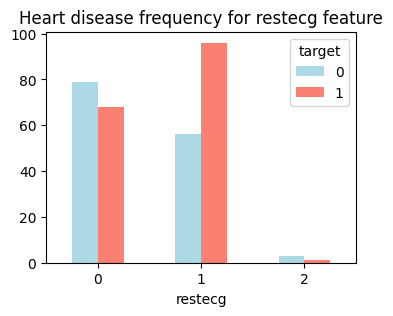

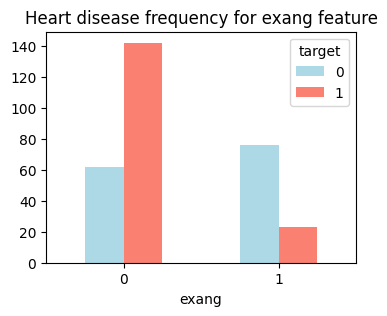

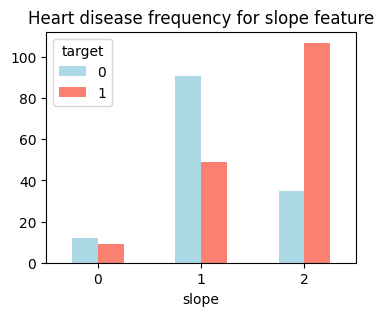

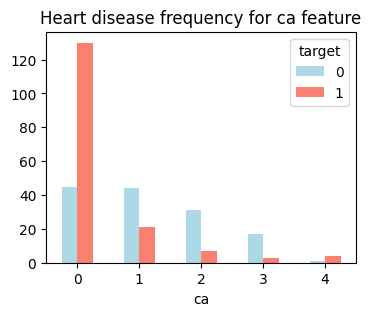

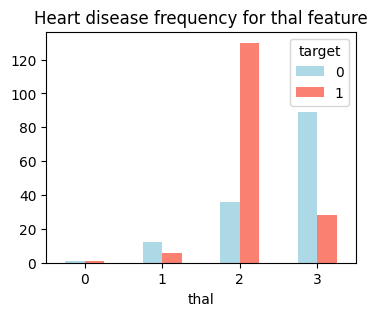

In [7]:
# compare discrete features with target

disc_feat = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for i in disc_feat:
    pd.crosstab(data[i], data['target']).plot(kind='bar', figsize=(4, 3), color=['lightblue', 'salmon'])
    plt.title('Heart disease frequency for ' + i + ' feature')
    plt.xticks(rotation=0)
    plt.show()

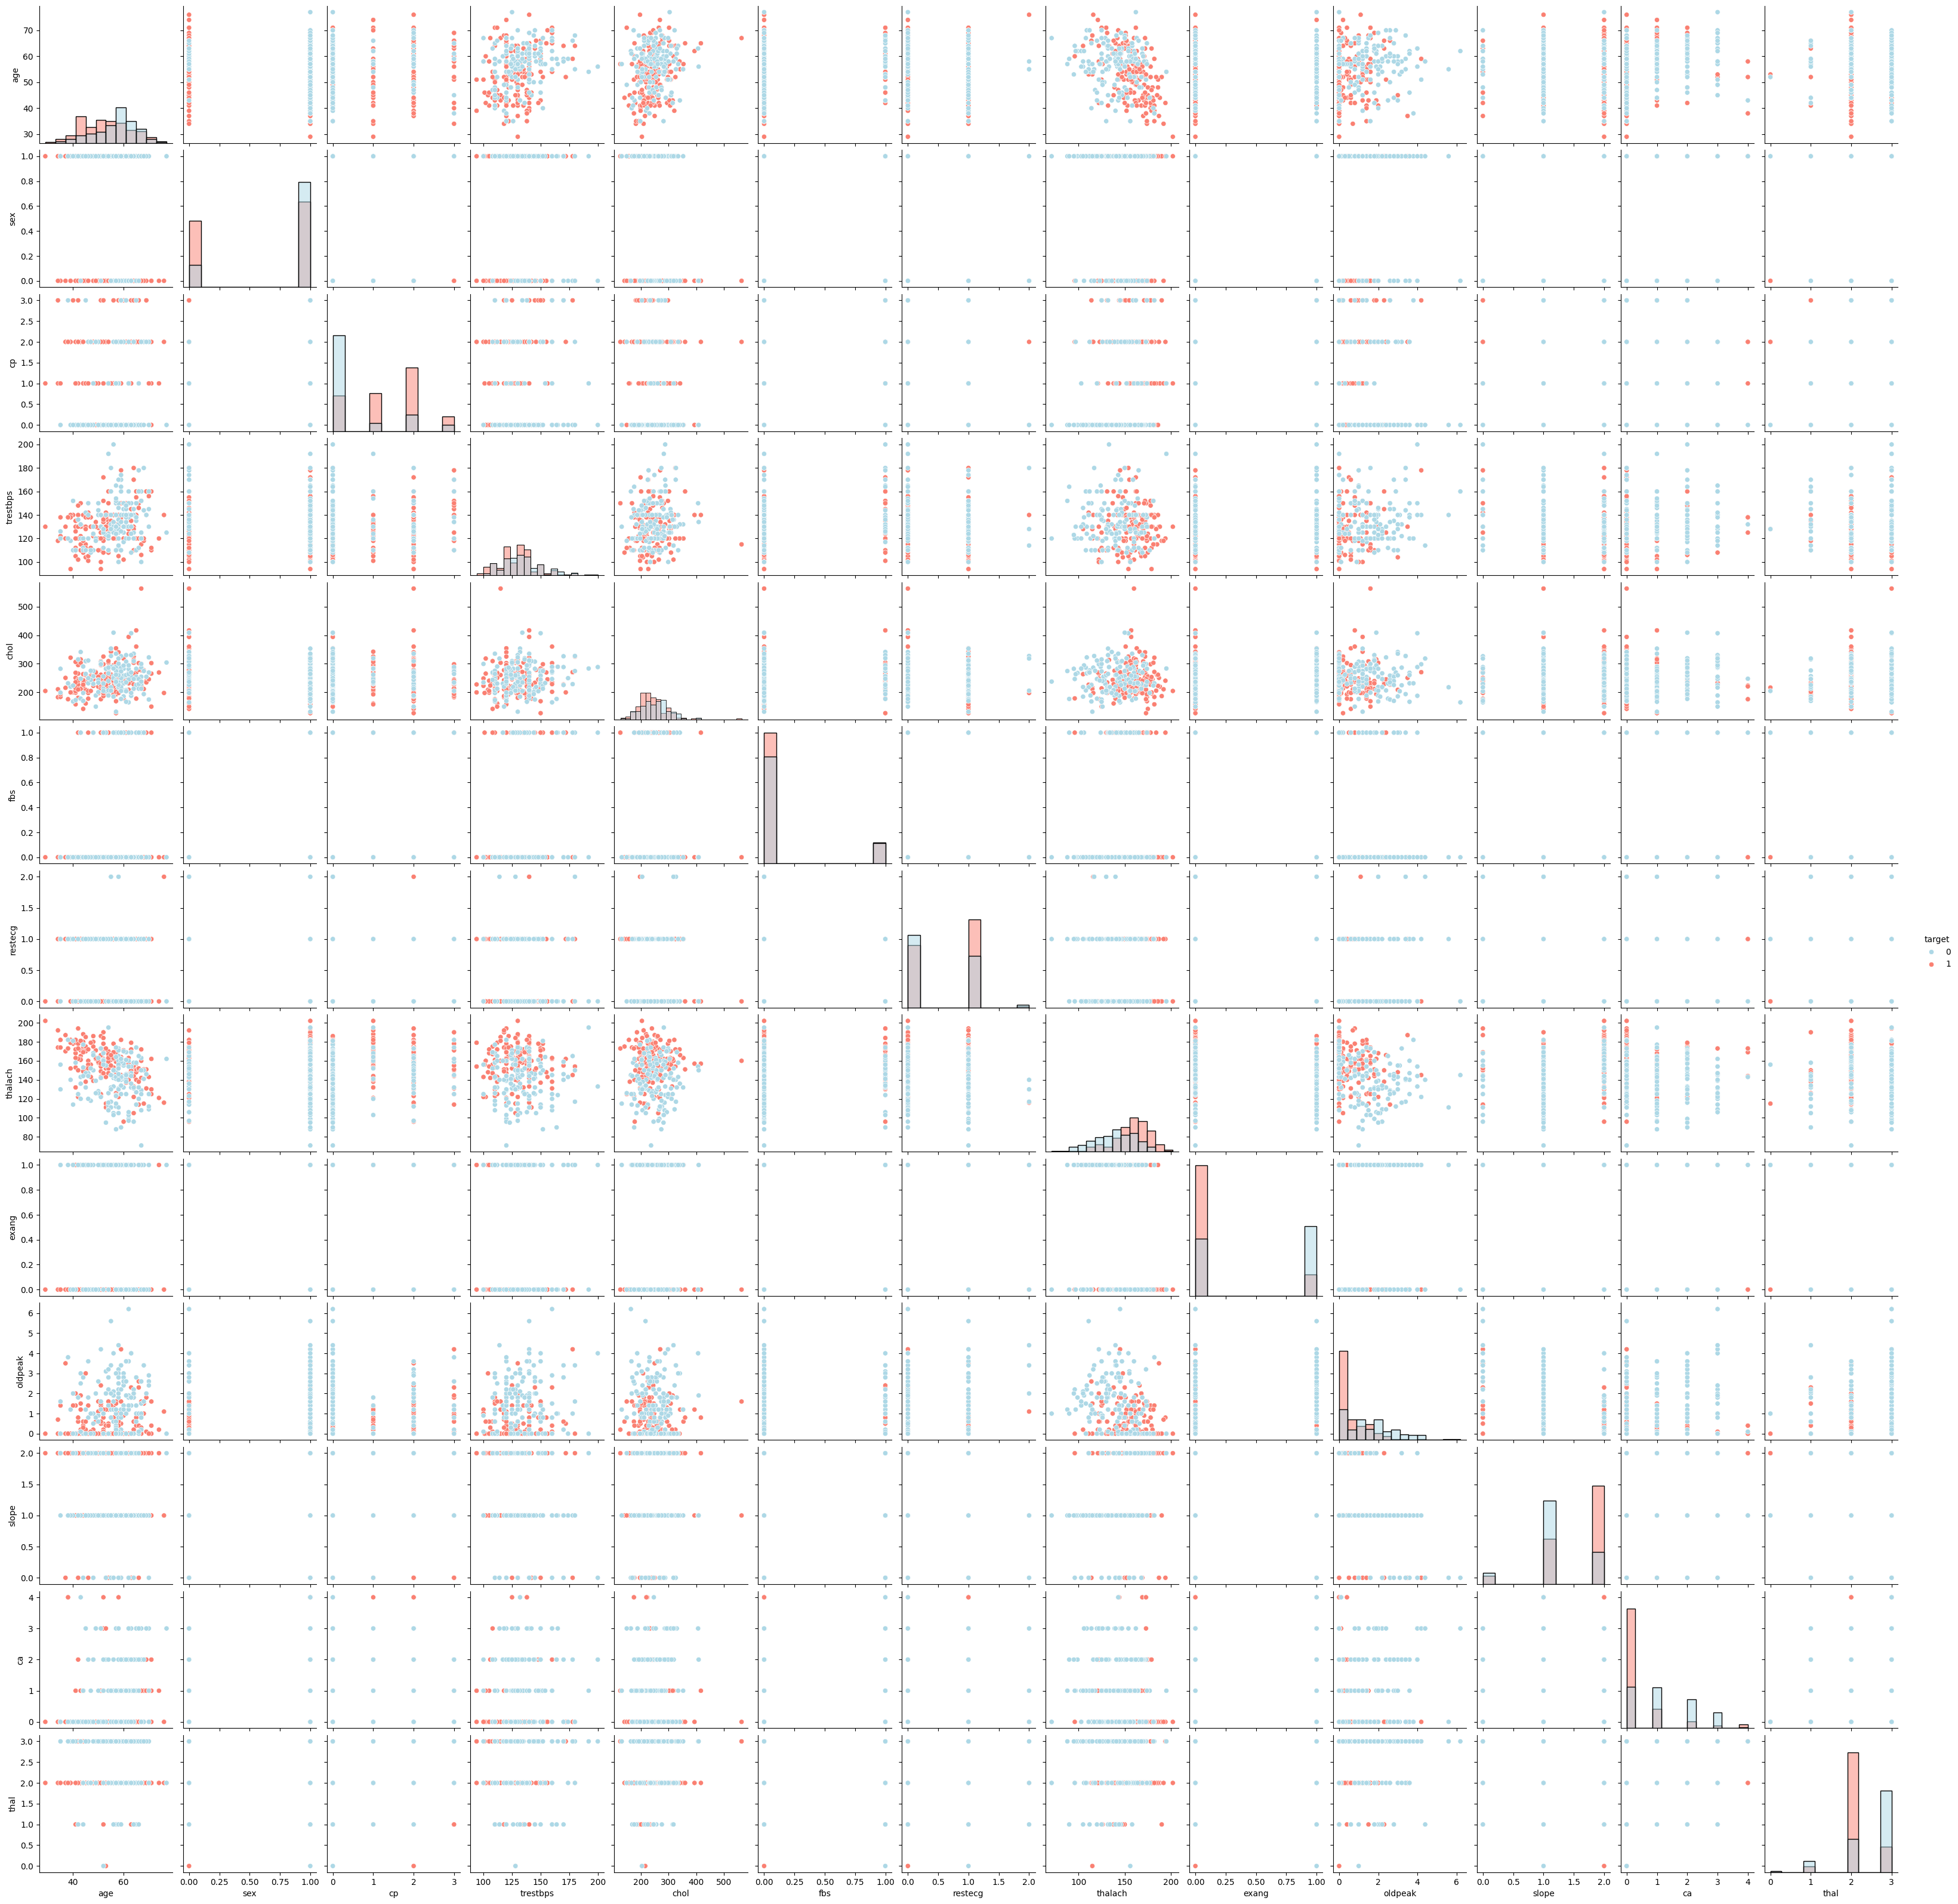

In [8]:
# pairplots

sns.pairplot(data=data, hue='target', palette={0:'lightblue', 1:'salmon'}, kind='scatter', diag_kind='hist')
plt.show()

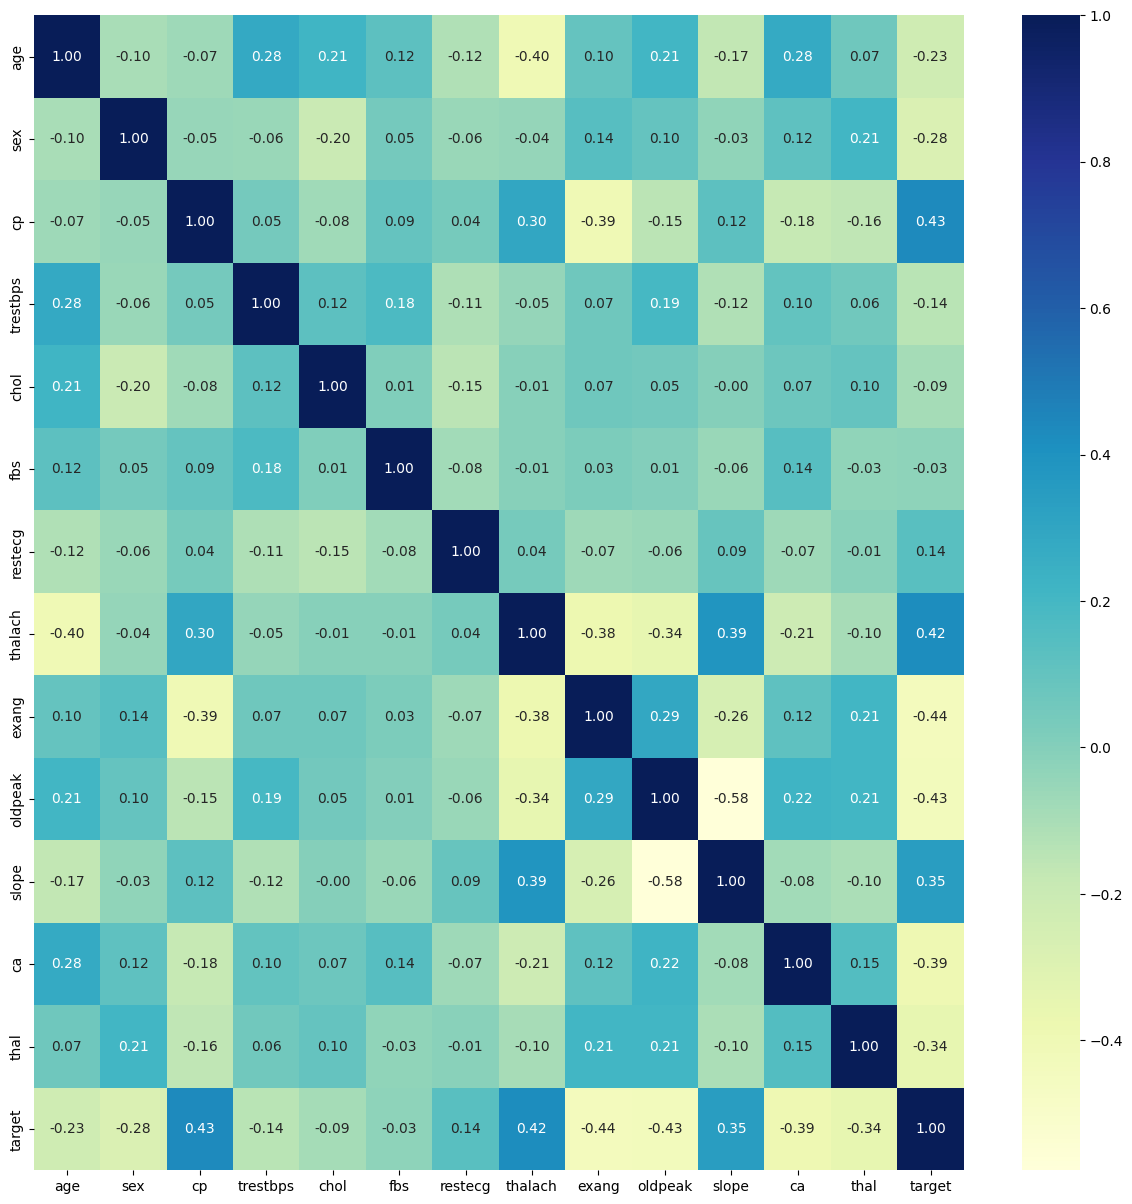

In [9]:
# correlation matrix

corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu')
plt.show()

In [10]:
X = data.drop('target', axis=1) # features
y = data['target'] # labels

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [12]:
# normalization

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

,LogisticRegression,kNN,RandomForest,AdaBoost
accuracy,0.770492,0.819672,0.803279,0.836066


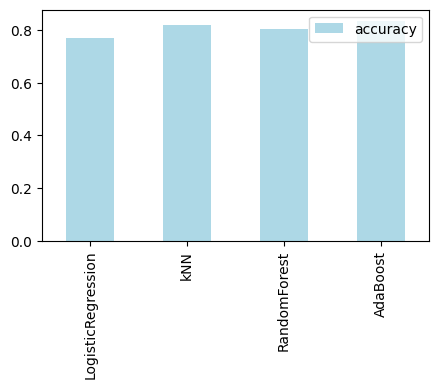

In [13]:
# baseline scores

models = {'LogisticRegression': LogisticRegression(),
         'kNN': KNeighborsClassifier(),
         'RandomForest': RandomForestClassifier(),
         'AdaBoost': AdaBoostClassifier()}

np.random.seed(10)    
model_scores = {}
    
for name, model in models.items():
    model.fit(X_train, y_train)
    model_scores[name] = model.score(X_test, y_test)

model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot(kind='bar', figsize=(5, 3), color='lightblue');

model_compare

In [14]:
# hyperparameter tuning with RandomizedSearchCV

log_reg_grid = {'C': np.logspace(-4, 4, 100),
               'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']}

knn_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
           'weights': ['uniform', 'distance'],
           'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

rf_grid = {'n_estimators': [10, 20, 50, 100, 200, 500, 1000],
          'criterion': ['gini', 'entropy', 'log_loss'],
          'min_samples_split': [2, 3, 4, 5],
          'min_samples_leaf': [1, 2, 3, 4, 5],
          'max_features': ['sqrt', 'log2', None]}

ada_boost_grid = {'estimator': [DecisionTreeClassifier(), RandomForestClassifier()],
                 'n_estimators': [5, 10, 20, 50, 100, 200],
                 'algorithm': ['SAMME', 'SAMME.R']}

rs_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_grid, cv=5, n_iter=50, random_state=10)
rs_log_reg.fit(X_train, y_train)
print(rs_log_reg.best_params_)

rs_knn = RandomizedSearchCV(KNeighborsClassifier(), knn_grid, cv=5, n_iter=50, random_state=10)
rs_knn.fit(X_train, y_train)
print(rs_knn.best_params_)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), rf_grid, cv=5, n_iter=50, random_state=10)
rs_rf.fit(X_train, y_train)
print(rs_rf.best_params_)

rs_ab = RandomizedSearchCV(AdaBoostClassifier(), ada_boost_grid, cv=5, n_iter=24, random_state=10)
rs_ab.fit(X_train, y_train)
print(rs_ab.best_params_)

C:\Users\ninam\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ninam\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ninam\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ninam\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ninam\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ninam\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

{'solver': 'liblinear', 'C': 1.9179102616724888}
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'kd_tree'}
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'gini'}
{'n_estimators': 100, 'estimator': RandomForestClassifier(), 'algorithm': 'SAMME'}


In [15]:
# hyperparameter tuning with GridSearchCV)

log_reg_grid = {'C': np.logspace(-2, 1, 20),
               'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga']}

knn_grid = {'n_neighbors': [3, 4, 5, 8],
           'weights': ['uniform', 'distance'],
           'algorithm': ['auto', 'ball_tree', 'kd_tree']}

rf_grid = {'n_estimators': [50, 100, 150, 200],
          'criterion': ['gini'],
          'min_samples_split': [2, 3, 4, 5],
          'min_samples_leaf': [1, 2, 3, 4, 5],
          'max_features': ['sqrt']}

ada_boost_grid = {'estimator': [DecisionTreeClassifier(), RandomForestClassifier()],
                 'n_estimators': [50, 100, 150, 200],
                 'algorithm': ['SAMME', 'SAMME.R']}

gs_log_reg = GridSearchCV(LogisticRegression(), log_reg_grid, cv=5)
gs_log_reg.fit(X_train, y_train)

gs_knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=5)
gs_knn.fit(X_train, y_train)

gs_rf = GridSearchCV(RandomForestClassifier(), rf_grid, cv=5)
gs_rf.fit(X_train, y_train)

gs_ab = GridSearchCV(AdaBoostClassifier(), ada_boost_grid, cv=5)
gs_ab.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'estimator': [DecisionTreeClassifier(),
                                       RandomForestClassifier()],
                         'n_estimators': [50, 100, 150, 200]})

In [16]:
models = {('Logistic Regression', gs_log_reg), ('kNN', gs_knn), ('Random Forest', gs_rf), ('Ada Boost', gs_ab)}

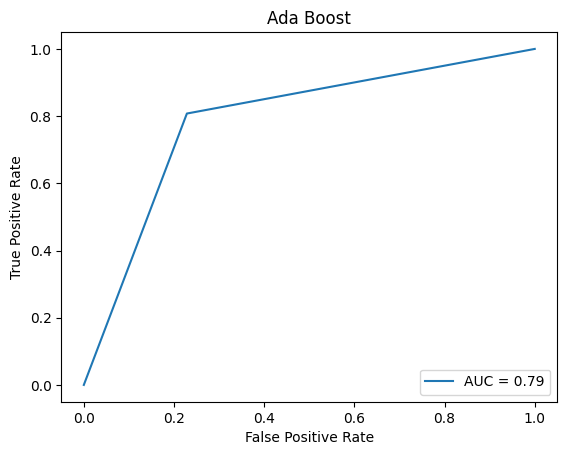

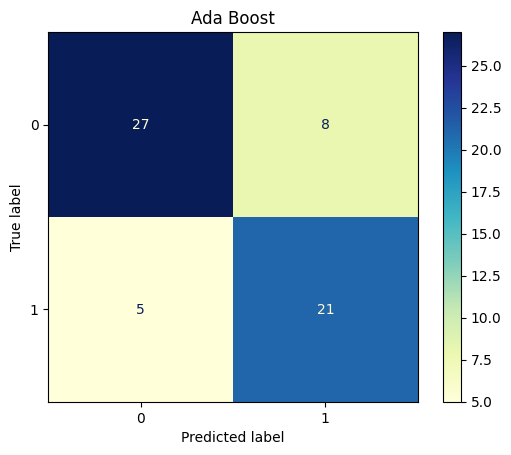

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.84      0.77      0.81        35
           1       0.72      0.81      0.76        26

    accuracy                           0.79        61
   macro avg       0.78      0.79      0.78        61
weighted avg       0.79      0.79      0.79        61



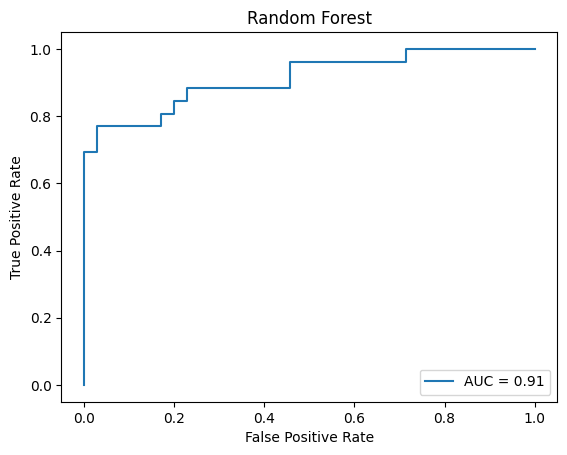

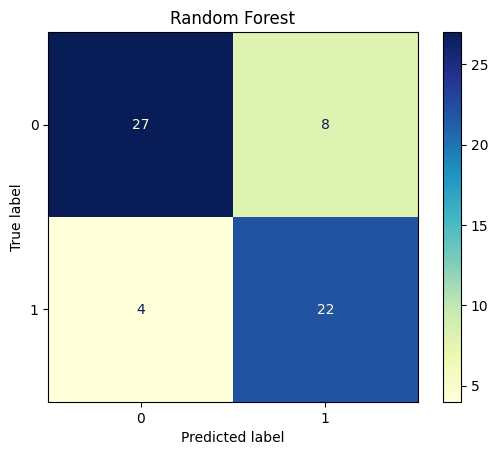

Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        35
           1       0.73      0.85      0.79        26

    accuracy                           0.80        61
   macro avg       0.80      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61



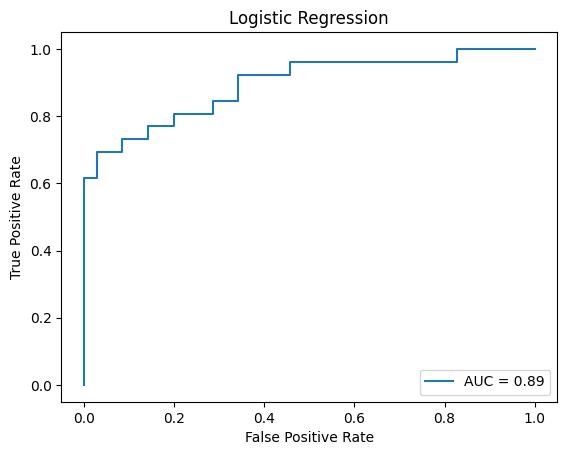

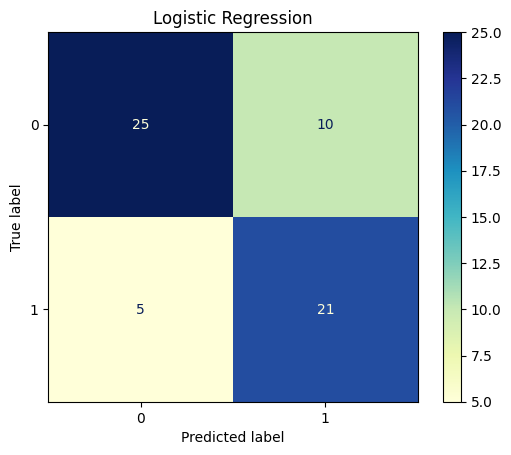

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        35
           1       0.68      0.81      0.74        26

    accuracy                           0.75        61
   macro avg       0.76      0.76      0.75        61
weighted avg       0.77      0.75      0.76        61



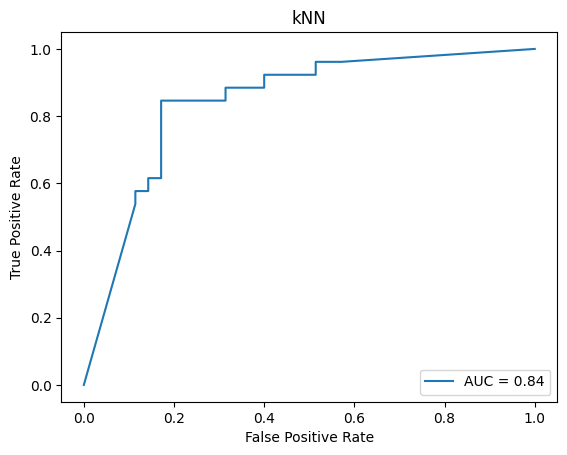

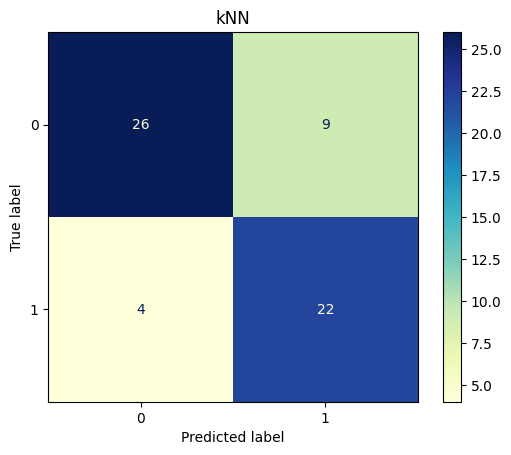

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        35
           1       0.71      0.85      0.77        26

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61



In [17]:
# model evaluation - ROC curve, confusion matrix, classification report

for model_name, model in models:
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    y_probs_positive = y_probs[:, 1] # probability of class 1

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.title(model_name)
    plt.show()

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='YlGnBu')
    plt.title(model_name)
    plt.show()

    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))